In [1]:
# !git clone https://github.com/ultralytics/yolov5
# %cd yolov5
# !pip install -r requirements.txt

In [31]:
# Import required libraries
%matplotlib inline
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
input_data = r"C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\Dataset"
output_data = r"C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\Dataset\Output"

In [4]:
annotations_path = os.path.join(input_data, "annotations")
images_path = os.path.join(input_data, "images")

In [5]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(annotations_path+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[os.path.basename(anno).split('.')[0]]
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [6]:
df=pd.DataFrame(dataset)
df.head()

file          name  width  height  xmin  ymin  xmax  ymax
0  maksssksksss0  without_mask    512     366    79   105   109   142
1  maksssksksss0     with_mask    512     366   185   100   226   144
2  maksssksksss0  without_mask    512     366   325    90   360   141
3  maksssksksss1     with_mask    400     156   321    34   354    69
4  maksssksksss1     with_mask    400     156   224    38   261    73

In [7]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

df['class'] = df['name'].map(name_dict)

In [8]:
np.sort(df.name.unique())


array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

In [9]:
fileNames = [*os.listdir(images_path)]
print('There are {} images in the dataset'.format(len(fileNames)))

There are 853 images in the dataset


In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [11]:
# Create necessary directories if they do not exist
os.makedirs(os.path.join(output_data, 'yolov5/data/train/images'), exist_ok=True)
os.makedirs(os.path.join(output_data, 'yolov5/data/train/labels'), exist_ok=True)
os.makedirs(os.path.join(output_data, 'yolov5/data/val/images'), exist_ok=True)
os.makedirs(os.path.join(output_data, 'yolov5/data/val/labels'), exist_ok=True)
os.makedirs(os.path.join(output_data, 'yolov5/data/test/images'), exist_ok=True)
os.makedirs(os.path.join(output_data, 'yolov5/data/test/labels'), exist_ok=True)

# Change the working directory
os.chdir(output_data)

In [12]:
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open(input_data+"/images/"+image)
        img1 = img.resize((640, 480))
        _ = img1.save(output_data+"/yolov5/data/"+folder_Name+"/images/"+image)

copyImages(train, "train")
copyImages(val, "val")
copyImages(test, "test")

In [13]:
df.head()

file          name  width  height  xmin  ymin  xmax  ymax  class
0  maksssksksss0  without_mask    512     366    79   105   109   142      2
1  maksssksksss0     with_mask    512     366   185   100   226   144      0
2  maksssksksss0  without_mask    512     366   325    90   360   141      2
3  maksssksksss1     with_mask    400     156   321    34   354    69      0
4  maksssksksss1     with_mask    400     156   224    38   261    73      0

In [14]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

In [15]:
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [16]:
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [17]:
df = df.astype('string')

In [18]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]
    
    for name in fileNames:
        data = df[df.file==name]
        
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open(output_data+"/yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)


create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

In [19]:
%cd yolov5

C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\Dataset\Output\yolov5


In [20]:
# to display images
from IPython.display import Image, clear_output
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5  2025-1-4 Python-3.12.8 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)


Setup complete  (12 CPUs, 31.1 GB RAM, 894.6/930.7 GB disk)


In [21]:
# configure .yaml file to guide the model for training
yaml_text = """train: ../data/train/images
val: 
nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

with open("data/data.yaml", 'r') as file:
    print(file.read())


train: ../data/train/images
val: 
nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']


In [22]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [23]:
%%writetemplate C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\models\custom_yolov5s.yaml
# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

In [24]:
import torch

# Print the device that PyTorch is using
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0)}")

Using device: NVIDIA GeForce RTX 4070 Ti


In [26]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [28]:
from datetime import datetime

start = datetime.now()
!python C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\yolov5\train.py --img 640 --batch 32 --epochs 80 --data C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\Dataset\Output\yolov5\data\data.yaml --cfg C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\models\custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache --device 0
end = datetime.now()

train: weights=yolov5s.pt, cfg=C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\models\custom_yolov5s.yaml, data=C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\Dataset\Output\yolov5\data\data.yaml, hyp=..\..\..\yolov5\data\hyps\hyp.scratch-low.yaml, epochs=80, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=..\..\..\yolov5\data\hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=..\..\..\yolov5\runs\train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-392-gf003c3df Python

In [29]:
print("Runtime =",end-start)

Runtime = 0:17:48.338217


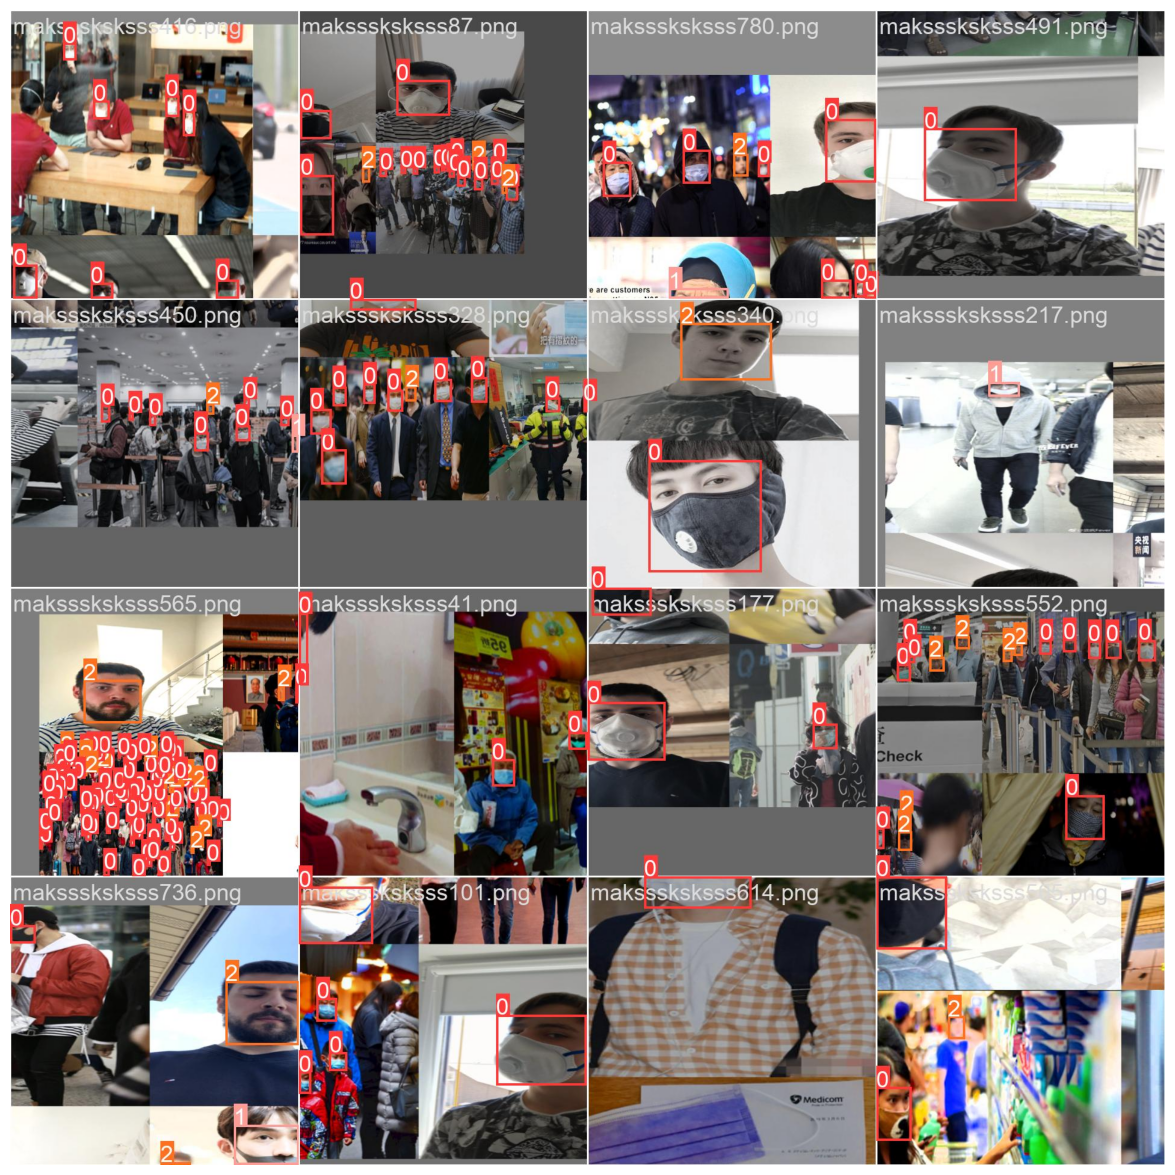

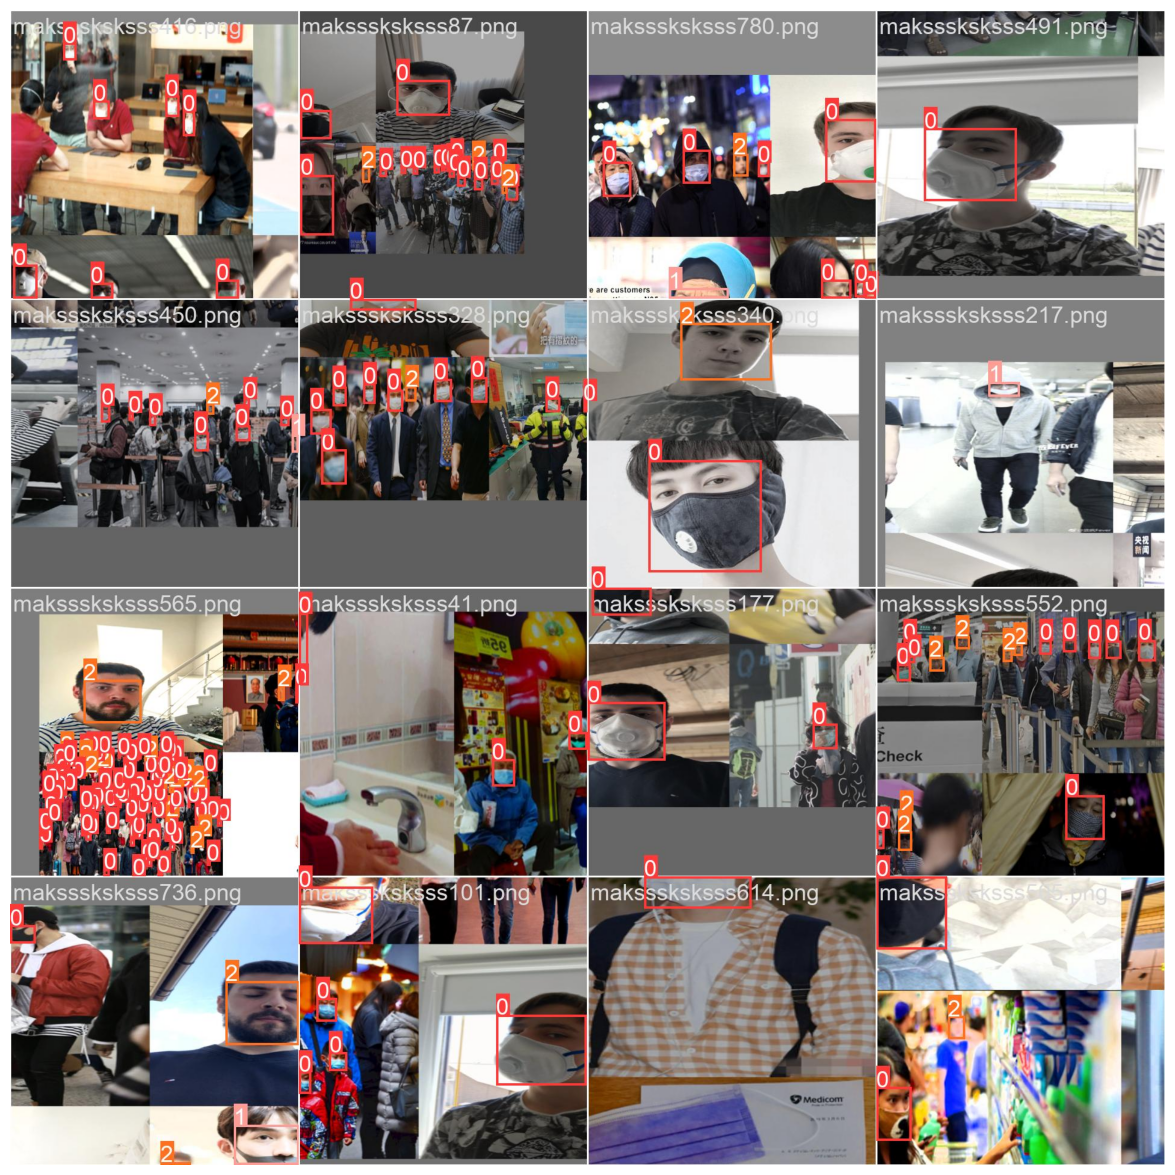

In [32]:
img = plt.imread(r"C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\yolov5\runs\train\yolov5s_results12\train_batch0.jpg")
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

In [33]:
!python C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\yolov5\detect.py --source C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\Dataset\Output\yolov5\data\test\images --weight C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\yolov5\runs\train\yolov5s_results3\weights\best.pt --name expTestImage --conf 0.2

detect: weights=['C:\\Users\\Kevem\\OneDrive\\Documents\\GitHub\\FaceMaskDetector\\yolov5\\runs\\train\\yolov5s_results3\\weights\\best.pt'], source=C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\Dataset\Output\yolov5\data\test\images, data=..\..\..\yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=..\..\..\yolov5\runs\detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-392-gf003c3df Python-3.12.8 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
image 1/190 C:\Users\Kevem\OneDrive\Documents\GitHub\FaceMaskDetector\Dataset\Output\yolov5\dat

In [34]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [35]:
def show_image(img_id):
    df_image = df[df.file==img_id]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'C:/Users/Kevem/OneDrive/Documents/GitHub/FaceMaskDetector/Dataset/Output/yolov5/data/test/images/'+img_id# +'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('C:/Users/Kevem/OneDrive/Documents/GitHub/FaceMaskDetector/yolov5/runs/detect/expTestImage3/'+ img_id)
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

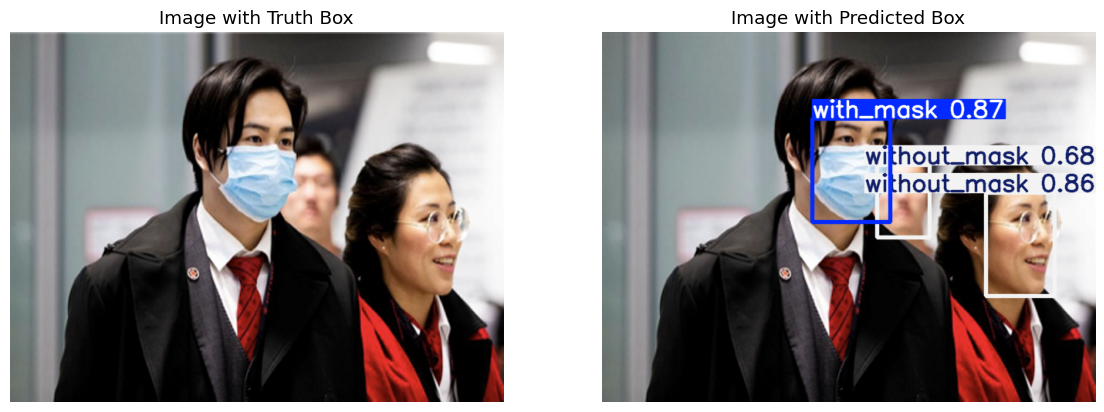

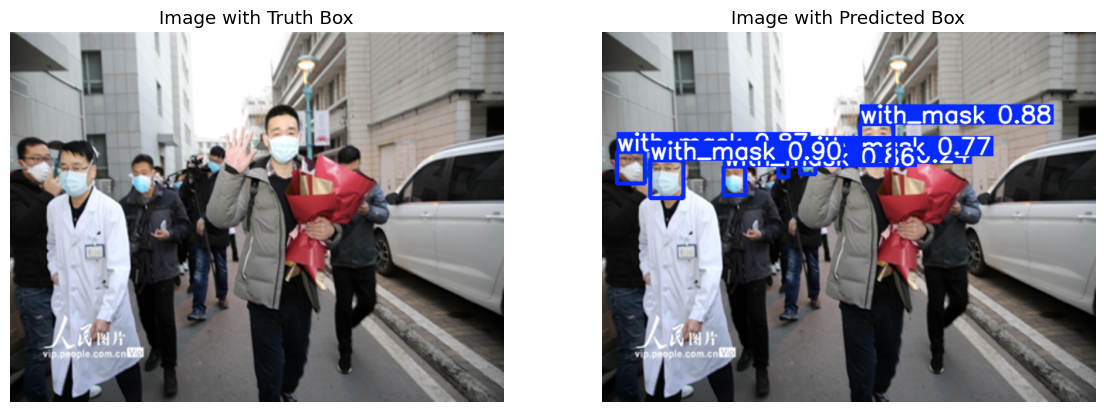

In [42]:
import random
show_image(random.choice(os.listdir('C:/Users/Kevem/OneDrive/Documents/GitHub/FaceMaskDetector/Dataset/Output/yolov5/data/test/images'))) 
show_image(random.choice(os.listdir('C:/Users/Kevem/OneDrive/Documents/GitHub/FaceMaskDetector/Dataset/Output/yolov5/data/test/images'))) 
plt.show()